In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import itertools
import random

%matplotlib inline

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)

### Haberman's Survival Data Set
The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.

Attribute Information:
1. Age of patient at time of operation (numerical)
2. Patient's year of operation (year - 1900, numerical)
3. Number of positive axillary nodes detected (numerical)
4. Survival status (class attribute)
-- 1 = the patient survived 5 years or longer
-- 2 = the patient died within 5 year

### EDA

In [2]:
df = pd.read_csv('haberman.data', header=None, names=['Age', 'operation_year', 'axillary_nodes', 'class'])
df.replace({'class': {2: 0}}, inplace=True)

In [3]:
df.head(3)

,Age,operation_year,axillary_nodes,class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1


In [4]:
df['class'].value_counts()

1    225
0     81
Name: class, dtype: int64

In [37]:
def get_metrics(y_true, preds):
    precision, recall, thresholds = precision_recall_curve(y_true, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    rocauc = roc_auc_score(y_true, preds)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}, roc_auc={rocauc:.3f}')
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], rocauc

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def evaluate_pipeline(pipeline, X_test, y_test):
    preds = pipeline.predict_proba(X_test)[:, 1]
    best_threshold, fscore, precision, recall, rocauc = get_metrics(y_test, preds)
    cnf_matrix = confusion_matrix(y_test, preds>best_threshold)
    plot_confusion_matrix(cnf_matrix, classes=['died', 'survived'],
                          title='Confusion matrix')
    plt.show()
    return best_threshold, fscore, precision, recall, rocauc

In [6]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


In [7]:
df = pd.read_csv('haberman.data', header=None, names=['Age', 'operation_year', 'axillary_nodes', 'class'])
df.replace({'class': {2: 0}}, inplace=True)

In [8]:
X = df.loc[:, ~df.columns.isin(['class'])]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=0, stratify=y)

Best Threshold=0.696, F-Score=0.866, Precision=0.786, Recall=0.965, roc_auc=0.737
Confusion matrix, without normalization


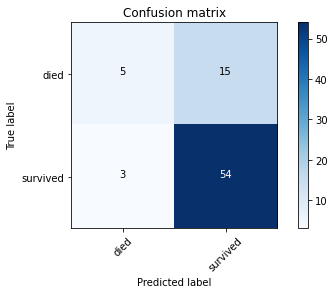

In [9]:
pipeline_logreg = Pipeline([
    ('classifier', LogisticRegression(random_state=0
                                     )),
])
pipeline_logreg.fit(X_train, y_train)
metrics = evaluate_pipeline(pipeline_logreg, X_test, y_test)

Best Threshold=0.548, F-Score=0.860, Precision=0.812, Recall=0.912, roc_auc=0.668
Confusion matrix, without normalization


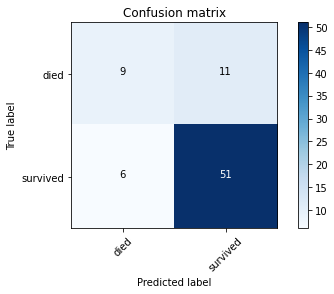

In [10]:
pipeline_GB = Pipeline([
    ('classifier', GradientBoostingClassifier(random_state=0,
                                              min_samples_leaf=4
                                             )),
])
pipeline_GB.fit(X_train, y_train)
metrics = evaluate_pipeline(pipeline_GB, X_test, y_test)

In [11]:
from catboost import CatBoostClassifier

Best Threshold=0.205, F-Score=0.867, Precision=0.825, Recall=0.912, roc_auc=0.758
Confusion matrix, without normalization


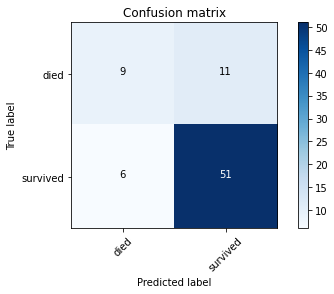

In [12]:
pipeline_cat = Pipeline([
    ('classifier', CatBoostClassifier(random_state=0,
                                      silent=True,
                                      class_weights={0: 10, 1: 1}
                                     )),
])
pipeline_cat.fit(X_train, y_train)
metrics = evaluate_pipeline(pipeline_cat, X_test, y_test)

4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [30]:
df = pd.read_csv('haberman.data', header=None, names=['Age', 'operation_year', 'axillary_nodes', 'class'])
df.replace({'class': {2: 0}}, inplace=True)
df['true_class'] = df['class']

In [31]:
df.value_counts('class')

class
1    225
0     81
dtype: int64

In [32]:
index_to_unlabel = list(df.loc[df['class'] == 0].sample(n=30, random_state=1).index)
df.loc[index_to_unlabel, 'class'] = 1

In [33]:
df.value_counts('class')

class
1    255
0     51
dtype: int64

In [17]:
data_P = df.loc[df['class'] == 0]
data_U = df.loc[df['class'] == 1]

5. применить random negative sampling для построения классификатора в новых условиях

In [39]:
NP = data_P.shape[0]
NU = data_U.shape[0]
T = 1000
K = NP
train_label = np.ones(shape=(NP+K,))
train_label[:NP] = 0
n_oob = np.ones(shape=(NU,))
f_oob = np.ones(shape=(NU, 2))

for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = data_P.append(data_U.iloc[bootstrap_sample, :])
    X_train = data_bootstrap.loc[:, ~data_bootstrap.columns.isin(['class', 'true_class'])]
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None, 
                                   criterion='gini', class_weight='balanced')
    model.fit(X_train, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    X_test = data_U.iloc[idx_oob]
    X_test = X_test.loc[:, ~data_bootstrap.columns.isin(['class', 'true_class'])]
    f_oob[idx_oob] += model.predict_proba(X_test)
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

In [40]:
data_U['predicted_class'] = predict_proba
data_P['predicted_class'] = 0
result = data_P.append(data_U)

<ipython-input-40-a27410bd9a6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_U['predicted_class'] = predict_proba
<ipython-input-40-a27410bd9a6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_P['predicted_class'] = 0


In [43]:
metrics = get_metrics(result['true_class'], result['predicted_class'])

Best Threshold=0.423, F-Score=0.938, Precision=0.882, Recall=1.000, roc_auc=0.810
